Época 0, Error MSE: 0.255482574890293
Época 1000, Error MSE: 0.23418173105004467
Época 2000, Error MSE: 0.19317434404123646
Época 3000, Error MSE: 0.16333989452686565
Época 4000, Error MSE: 0.14665401219534022
Época 5000, Error MSE: 0.138531965663235
Época 6000, Error MSE: 0.1342972415400368
Época 7000, Error MSE: 0.13186887238316725
Época 8000, Error MSE: 0.13035507481236927
Época 9000, Error MSE: 0.12934461244178191
Predicciones para XOR: [[0]
 [1]
 [1]
 [1]]
Error final: 0.12863292444633895


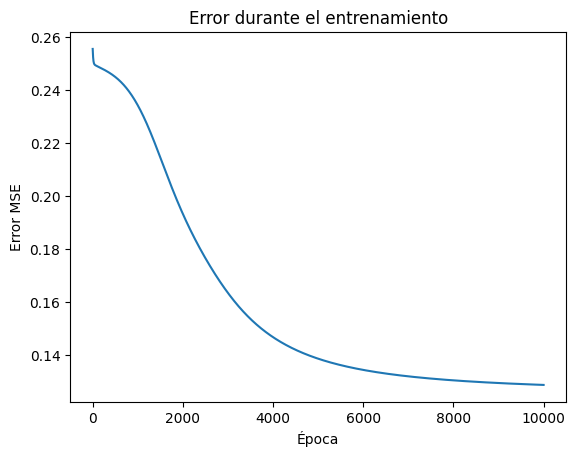

In [ ]:
import numpy as np

class TwoLayersPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, epochs=10000):
        # Pesos entrada a oculta: matriz aleatoria tamaño (input x ocultas)
        self.W1 = np.random.randn(input_size, hidden_size)
        # Sesgos capa oculta: vector ceros tamaño (1 x ocultas)
        self.b1 = np.zeros((1, hidden_size))
        # Pesos oculta a salida: matriz aleatoria tamaño (ocultas x salida)
        self.W2 = np.random.randn(hidden_size, output_size)
        # Sesgos capa salida: vector ceros tamaño (1 x salida)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.epochs = epochs

    def sigmoid(self, x):
        # Función activación sigmoide
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        # Derivada sigmoide, x aquí ya es la salida de la sigmoide
        return x * (1 - x)

    def forward(self, X):
        # Propagación hacia adelante
        self.z1 = np.dot(X, self.W1) + self.b1  # Suma ponderada capa oculta
        self.a1 = self.sigmoid(self.z1)         # Activación capa oculta
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Suma ponderada capa salida
        self.output = self.sigmoid(self.z2)     # Activación salida
        return self.output

    def backward(self, X, y):
        # Cálculo del error en la salida
        error = y - self.output  # Diferencia salida deseada - salida actual
        # Gradiente capa salida
        d_output= error * self.sigmoid_derivative(self.output)

        # Error y gradiente capa oculta
        error_hidden = d_output.dot(self.W2.T)
        d_hidden = error_hidden * self.sigmoid_derivative(self.a1)

        # Actualización pesos y sesgos capas
        self.W2 += self.a1.T.dot(d_output) * self.learning_rate
        self.b2 += np.sum(d_output, axis=0, keepdims=True) * self.learning_rate
        self.W1 += X.T.dot(d_hidden) * self.learning_rate
        self.b1 += np.sum(d_hidden, axis=0, keepdims=True) * self.learning_rate

    def fit(self, X, y):
        self.errors = []  # Para seguimiento del error
        for epoch in range(self.epochs):
            self.forward(X)      # Propagación adelante
            self.backward(X, y)  # Retropropagar y actualizar pesos
            mse = np.mean((y - self.output) ** 2)  # Error cuadrático medio
            self.errors.append(mse)               # Guardar error
            if epoch % 1000 == 0:
                print(f"Época {epoch}, Error MSE: {mse}")

    def predict(self, X):
        output = self.forward(X)
        # Clasificación binary usando umbral 0.5
        return (output > 0.5).astype(int)

# --- EJEMPLO: función XOR
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([[0], [1], [1], [0]])

# Crear el modelo con 2 neuronas ocultas, tasa aprendizaje 0.1, 10000 épocas
mlp = TwoLayersPerceptron(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1, epochs=10000)
mlp.fit(X, y)

# Predicción final
print("Predicciones para XOR:", mlp.predict(X))
print("Error final:", mlp.errors[-1])

# Opcional: graficar error
import matplotlib.pyplot as plt
plt.plot(mlp.errors)
plt.xlabel('Época')
plt.ylabel('Error MSE')
plt.title('Error durante el entrenamiento')
plt.show()


Monitorizacion del entrenamiento del modelo.

Época 0, Error MSE: 0.2961522472746746
Época 500, Error MSE: 0.24846063108797445
Época 1000, Error MSE: 0.2451310740357272
Época 1500, Error MSE: 0.23292799674004352
Época 2000, Error MSE: 0.20280619295547406
Época 2500, Error MSE: 0.17236107306522538
Época 3000, Error MSE: 0.1540428174467943
Época 3500, Error MSE: 0.14438561999602928
Época 4000, Error MSE: 0.1390556262023654
Época 4500, Error MSE: 0.13584021521567408
Época 5000, Error MSE: 0.13374070746559508
Época 5500, Error MSE: 0.13228157569578125
Época 6000, Error MSE: 0.1312171555535907
Época 6500, Error MSE: 0.13041056828857212
Época 7000, Error MSE: 0.12978050619089365
Época 7500, Error MSE: 0.12927603184695052
Época 8000, Error MSE: 0.1288637886890163
Época 8500, Error MSE: 0.12852110565320002
Época 9000, Error MSE: 0.12823208093825184
Época 9500, Error MSE: 0.12798525588957338
Época 9999, Error MSE: 0.1277725758388958


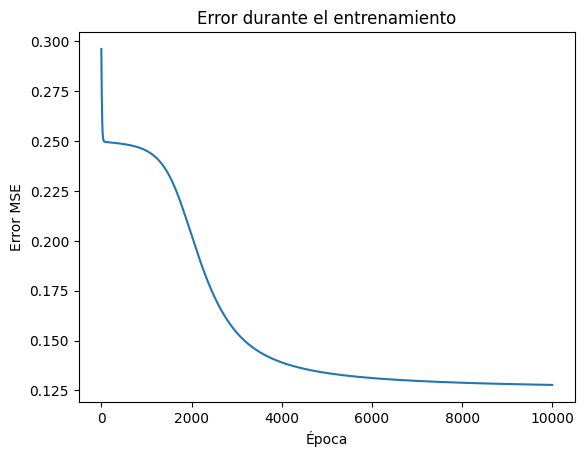

Predicciones: [[0]
 [0]
 [1]
 [1]]


In [9]:
import numpy as np
import matplotlib.pyplot as plt

class TwoLayersPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1, epochs=10000):
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.errors = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.output = self.sigmoid(self.z2)
        return self.output

    def backward(self, X, y):
        error = y - self.output
        d_output = error * self.sigmoid_derivative(self.output)
        error_hidden = d_output.dot(self.W2.T)
        d_hidden = error_hidden * self.sigmoid_derivative(self.a1)
        self.W2 += self.a1.T.dot(d_output) * self.learning_rate
        self.b2 += np.sum(d_output, axis=0, keepdims=True) * self.learning_rate
        self.W1 += X.T.dot(d_hidden) * self.learning_rate
        self.b1 += np.sum(d_hidden, axis=0, keepdims=True) * self.learning_rate

    def fit(self, X, y):
        for epoch in range(self.epochs):
            self.forward(X)
            self.backward(X, y)
            mse = np.mean((y - self.output) ** 2)
            self.errors.append(mse)
            if epoch % 500 == 0 or epoch == self.epochs - 1:
                print(f"Época {epoch}, Error MSE: {mse}")

    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

    def plot_errors(self):
        plt.plot(self.errors)
        plt.xlabel('Época')
        plt.ylabel('Error MSE')
        plt.title('Error durante el entrenamiento')
        plt.show()
# Datos XOR
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([[0], [1], [1], [0]])

mlp = TwoLayersPerceptron(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1, epochs=10000)
mlp.fit(X, y)
mlp.plot_errors()
print("Predicciones:", mlp.predict(X))


Aproximación de función (regresión) con datos adjuntos

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
data_train = pd.read_parquet('data_train.parquet')
data_test = pd.read_parquet('data_test.parquet')

#para ver como se llaman las columnas
print(data_train.columns)
print(data_test.columns)

import pandas as pd

# Cambia la ruta por la de tu archivo
df = pd.read_parquet("data_test.parquet", engine="pyarrow")

# Muestra las primeras filas
print(df.head())

df = pd.read_parquet("data_train.parquet", engine="pyarrow")

# Muestra las primeras filas
print(df.head())



Index(['X', 'Y'], dtype='object')
Index(['X', 'Y'], dtype='object')
         X         Y
0 -5.00000 -0.000078
1 -4.98999 -0.000081
2 -4.97998 -0.000085
3 -4.96997 -0.000089
4 -4.95996 -0.000093
        X         Y
0 -5.0000 -0.000078
1 -4.8999 -0.000122
2 -4.7998 -0.000190
3 -4.6997 -0.000292
4 -4.5996 -0.000445


In [11]:
import numpy as np


# Usar 'X' como entrada y 'Y' como salida
X_train = data_train[['X']].values  # Entrada
y_train = data_train[['Y']].values  # Salida
X_test = data_test[['X']].values
y_test = data_test[['Y']].values

# Definir el perceptrón multicapa para regresión
class TwoLayersPerceptronReg:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=5000):
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.errors = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.output = self.z2  # Para regresión, salida lineal
        return self.output

    def backward(self, X, y):
        error = y - self.output
        d_output = error  # Derivada de identidad es 1
        error_hidden = d_output.dot(self.W2.T)
        d_hidden = error_hidden * self.sigmoid_derivative(self.a1)
        self.W2 += self.a1.T.dot(d_output) * self.learning_rate
        self.b2 += np.sum(d_output, axis=0, keepdims=True) * self.learning_rate
        self.W1 += X.T.dot(d_hidden) * self.learning_rate
        self.b1 += np.sum(d_hidden, axis=0, keepdims=True) * self.learning_rate

    def fit(self, X, y):
        for epoch in range(self.epochs):
            self.forward(X)
            self.backward(X, y)
            mse = np.mean((y - self.output) ** 2)
            self.errors.append(mse)
            if epoch % 500 == 0 or epoch == self.epochs - 1:
                print(f"Época {epoch}, Error MSE: {mse}")

    def predict(self, X):
        return self.forward(X)

    def plot_errors(self, rango_y=None):
        if rango_y:
            plt.ylim(*rango_y)
        plt.plot(self.errors)
        plt.xlabel('Época')
        plt.ylabel('Error MSE')
        plt.title('Error durante el entrenamiento')
        plt.show()

configuraciones = [
    {"hidden_size": 5, "learning_rate": 0.01, "epochs": 5000},
    {"hidden_size": 10, "learning_rate": 0.01, "epochs": 5000},
    {"hidden_size": 20, "learning_rate": 0.005, "epochs": 8000},
    {"hidden_size": 50, "learning_rate": 0.001, "epochs": 15000},
]

mejor_mse = float('inf')
mejor_config = None

for config in configuraciones:
    print(f"Probando configuración: {config}")
    mlp = TwoLayersPerceptronReg(
        input_size=1,
        hidden_size=config["hidden_size"],
        output_size=1,
        learning_rate=config["learning_rate"],
        epochs=config["epochs"]
    )
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    mse_test = np.mean((y_test - y_pred) ** 2)
    print(f"MSE en test: {mse_test}")
    if mse_test < mejor_mse:
        mejor_mse = mse_test
        mejor_config = config

print(f"\nMejor configuración: {mejor_config} con MSE en test: {mejor_mse}")




Probando configuración: {'hidden_size': 5, 'learning_rate': 0.01, 'epochs': 5000}
Época 0, Error MSE: 2.241628683838059
Época 500, Error MSE: 0.021296696979209516
Época 1000, Error MSE: 0.019864921483471496
Época 1500, Error MSE: 0.019432737296462752
Época 2000, Error MSE: 0.019055061331231866
Época 2500, Error MSE: 0.0182852454596511
Época 3000, Error MSE: 0.016184626719873918
Época 3500, Error MSE: 0.012028602373154808
Época 4000, Error MSE: 0.007502755746644776
Época 4500, Error MSE: 0.0043391559554971605
Época 4999, Error MSE: 0.002500038340543151
MSE en test: 0.008999968055386729
Probando configuración: {'hidden_size': 10, 'learning_rate': 0.01, 'epochs': 5000}
Época 0, Error MSE: 1.5051225579333252
Época 500, Error MSE: 0.003706288457081779
Época 1000, Error MSE: 0.001986922303175331
Época 1500, Error MSE: 0.0005352325473554895
Época 2000, Error MSE: 0.00026633712780793644
Época 2500, Error MSE: 0.00017488991977007506
Época 3000, Error MSE: 0.00013374722404356861
Época 3500, Erro